# TP Integrador N° 1 
#### Grupo 10

Integrantes:
- Rodrigo Gramajo
- Facundo Peloso
- Guido Perez 
- Roberto Biancardi

Introducción

La inmobiliaria Properatti desea implementar un ***tasador automático*** para sus operaciones.

Nuestro objetivo final es desarrollar un modelo de regresión lineal que permita *predecir el* ***precio por metro cuadrado*** *de una propiedad.* Para ello, la empresa nos provee un dataset con los datos de sus operaciones en el primer semestre del 2017.

El alcance de este primer trabajo práctico es de leer, analizar y procesar dichos datos para desarrollar un modelo predictivo en próximos trabajos.



### Lectura de Datos ###


Importamos las librerías que nos permitiran manejar y visualizar los datos

In [69]:
#Importacion de librerias/módulos
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import collections

Leemos el archivo .csv que contiene al dataset y  hacemos una primera visualización.

NOTA: El archivo .csv esta ubicado en el mismo directorio que la notebook Main para evitar conflictos de distintas rutas locales.

In [70]:
#Establezco la dirección del archivo
file_location='properatti.csv'

#Leo el data set usando la librería pandas
# y se almacena en el objeto Dataframe llamado datos_crudos  
datos_crudos=pd.read_csv(file_location)

#Visualizo las primeras filas
display(datos_crudos.head(3))

,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
0,0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,...,40.0,1127.272727,1550.000000,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...
1,1,sell,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...
2,2,sell,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6522615,-58.5229825",-34.652262,...,55.0,1309.090909,1309.090909,NaN,NaN,NaN,http://www.properati.com.ar/15bod_venta_depart...,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,https://thumbs4.properati.com/5/SXKr34F_IwG3W_...


### Dimensiones del Dataset ###
Visualizamos la dimensión del dataset en filas *(Registros)* y columnas *(Campos)*:

In [71]:
#Imprimimos en pantalla la cantidad de filas y columnas
print('Tamaño del dataset')
print('Filas:',datos_crudos.shape[0])
print('Columnas:',datos_crudos.shape[1])

Tamaño del dataset
Filas: 121220
Columnas: 26


Hay mas 120 mil registro por lo que es de tamaño chico/mediano.

Cuenta con 26 campos para describir cada operacion inmobiliaria.

### Analisis de los Campos ###

Listamos todos los campos del dataset y el tipo de dato que almacenan para entender que información nos brindan

In [72]:
#Instanciamos un Serie vacía
nombre_tipo_columnas=pd.Series()
#Utilizamos las columnas de nuestro dataset como índice de la serie vacía
# como valores guardamos el tipo de objeto almacenado en la primera fila de cada columna
for i in datos_crudos.columns : 
     nombre_tipo_columnas[i]=type(datos_crudos.loc[0,i])
nombre_tipo_columnas


C:\Users\rodri\AppData\Local\Temp\ipykernel_13116\1820039734.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  nombre_tipo_columnas=pd.Series()


Unnamed: 0                      <class 'numpy.int64'>
operation                               <class 'str'>
property_type                           <class 'str'>
place_name                              <class 'str'>
place_with_parent_names                 <class 'str'>
country_name                            <class 'str'>
state_name                              <class 'str'>
geonames_id                   <class 'numpy.float64'>
lat-lon                                 <class 'str'>
lat                           <class 'numpy.float64'>
lon                           <class 'numpy.float64'>
price                         <class 'numpy.float64'>
currency                                <class 'str'>
price_aprox_local_currency    <class 'numpy.float64'>
price_aprox_usd               <class 'numpy.float64'>
surface_total_in_m2           <class 'numpy.float64'>
surface_covered_in_m2         <class 'numpy.float64'>
price_usd_per_m2              <class 'numpy.float64'>
price_per_m2                

### Listado y breve descripción de cada campo ###

- "Unnamed: 0": Es un campo que hace la función de índice. Cada registro es un valor numérico, entero, único y ordenado desde el 0 hasta el total de filas menos uno.

- "operation": String que define el tipo de operación: venta(sell) o alquiler(rent).

- property_type: String que define el tipo de propiedad (PH, Casa, Departamento)

- place_name: String que define el barrio/ciudad de la propiedad

- place_with_parent_names: String con diferentes datos geograficos separados por un caracter
 (pais, nombre, provincia, ciudad).

- country_name: String que define el país de la propiedad.

- state_name: String que indica la provincia/región de la propiedad.

- geonames_id:

- lat-lon: Latitud y Longitud separados por un caracter.

- lat: Latidud

- lon: Longitud

- price: Precio 

- currency: Moneda 

- price_aprox_local_currency: Precio en moneda local.

- price_aprox_usd: Precio aproximado en dólares

- surface_total_in_m2: Superficie total en metros cuadrados.

- surface_covered_in_m2: Superficie cubierta/bajo techo en metros cuadrados.

- price_usd_per_m2: Precio en dolar del metro cuadrado de la propiedad.

- price_per_m2: Precio en monedad local del metro cuadrado de la propiedad.

- floor: String que indica el piso en el que se encuentra el departamento o cantidad de pisos que tiene una casa.

- rooms: Cantidad de  ambientes que tiene la propiedad.

- expenses: Valor de las expensas.

- properati_url

- description

- title

- image_thumbnail

### Analisis de los campos del Dataset ###


##### Eliminación de campos redundantes: ####

Creamos una lista vacía donde iremos añadiendo los campos redundantes que serán eliminados

In [73]:
#Lista vacía de campos a eliminar:
campos_a_eliminar=[]

**Unnamed 0:** - Esta columna no tiene ninguna utilidad o función ya que volcamos el dataset a un objeto Dataframe que ya cuenta con su propio índice. Por ende se descarta.

In [74]:
#añadimos el campo a la lista eliminar
campos_a_eliminar.append('Unnamed: 0')

**Operation:** - Esta columna debería tener dos tipos de valores posibles (venta y alquiler). Podemos corrobar cuantos operaciones fueron venta y cuantas alquiler:

In [75]:
#Utilizamos el método value_counts para totalizar las operaciones de venta y alquier 
datos_crudos.operation.value_counts()

sell    121220
Name: operation, dtype: int64

Vemos que todas las operaciones realizadas han sido de ventas y ninguna de alquiler. Por lo tanto, esta columna no me aporta información y se descarta.

In [76]:
#añadimos el campo a la lista eliminar
campos_a_eliminar.append('operation')

**country_name** - A priori se debería descartar ya que, por definición, partimos de la base que la inmobiliaria Properatti es una empresa argentina que opera solo en dicho país. No obstante, podemos corroborar si todos los registros del campo country_name coinciden y son efectivamente "Argentina":

In [77]:
#Utilizamos el método value_counts para totalizar los valores distinto que aparecen
#en la columna country_name
datos_crudos.country_name.value_counts()

Argentina    121220
Name: country_name, dtype: int64

Confirmamos que todos los registros tiene el mismo valor por lo que el campo no aporta información y se decarta la columna.

In [78]:
#añadimos el campo a la lista eliminar
campos_a_eliminar.append('country_name')

place_with_parent_names: Es un campo que contiene la misma información que place_name, state_name y country_name separados
por un caracter "|".

A priori, uno podría descartar esta columna y quedarse con las columnas que cuentan con los valores ya separados.

Sin embargo, vemos que place_name tiene registros nulos y place_with_parent_names no:

In [79]:
datos_crudos[['state_name','place_name','place_with_parent_names']].isnull().sum()

state_name                  0
place_name                 23
place_with_parent_names     0
dtype: int64

Por esto decidimos quedarnos con la ccolumna place_with_parent_names que tiene toda la mayor cantidad de información, 
a pesar que luego tendremos que procesarla.

Descartamos los campos state_name y place_name:

In [80]:
#añadimos los campos a la lista eliminar
campos_a_eliminar.extend(('state_name','place_name'))

geonames_id: Corresponde a una base de datos que asigna latitud y longitud a ciudades, provincias y otras
entidades geográficas.

No es útil para imputar las columnas de latitud y longitud ya que si queremos analizar los precios de las propiedades por barrio, esto introduciría un sesgo a los datos y empeoraría el valor predictivo
de nuestro modelo. Por ende se descarta

In [81]:
#añadimos los campos a la lista eliminar
campos_a_eliminar.append('geonames_id')


lat-lon: Tiene los datos de latitud y longitud separados por un caracter "-".
Podríamos descartala y utilizar las columnas lat y lon en su lugar. Pero primero corroboramos la calidad
de las columnas según cantidad de nulos:

In [82]:
#Vemos la cantidad de nulos en las columnas:
datos_crudos[['lat-lon','lat','lon']].isnull().sum()

lat-lon    51550
lat        51550
lon        51550
dtype: int64

Como tienen la misma cantidad de datos, descartamos la columna lat-lon.

In [83]:
#añadimos los campos a la lista eliminar
campos_a_eliminar.append('lat-lon')

Ahora analizamos las columnas correspondientes al precio de las propiedades

Tenemos las columnas price (precio en dólares), currency(moneda en que se cotiza), 
price_aprox_local_currency (precio aproximado en pesos) y price_aprox_usd (precio aproximado en dólares)


Por un lado vemos que monedas se usaron para cotizar:

In [84]:
#Vemos cuantas monedas se utilizaron
datos_crudos.currency.value_counts()

USD    87587
ARS    13219
PEN        2
UYU        1
Name: currency, dtype: int64

La gran mayoria de las cotizaciones fue en dólares. Deberíamos tener una única columna con el precio de las propiedades en dólares.

Ahora vemos si los precios en pesos han usado el mismo tipo de cambio:

In [85]:
#Creamos un df dividiendo el precio aproximado en pesos por el precio aproximado en dólares
valor_de_cambio=datos_crudos.price_aprox_local_currency/datos_crudos.price_aprox_usd

#Vemos cuantas cotizaciones hubo
valor_de_cambio.value_counts()

17.6445    82402
17.6445      714
17.6445      670
17.6445      224
17.6445      224
           ...  
17.6445        1
17.6445        1
17.6445        1
17.6445        1
17.6445        1
Length: 7238, dtype: int64

In [86]:
print(datos_crudos.loc[datos_crudos.currency=='PEN'][['price','price_aprox_usd','price_aprox_local_currency','currency']])
print(datos_crudos.loc[50387,'price_aprox_local_currency']/datos_crudos.loc[50387,'price_aprox_usd'])
print(datos_crudos.loc[50388,'price_aprox_local_currency']/datos_crudos.loc[50388,'price_aprox_usd'])

print(datos_crudos.loc[datos_crudos.currency=='UYU'][['price','price_aprox_usd','price_aprox_local_currency','currency']])
print(datos_crudos.loc[107390,'price_aprox_local_currency']/datos_crudos.loc[107390,'price_aprox_usd'])

          price  price_aprox_usd  price_aprox_local_currency currency
50387  380000.0        117139.33                  2066864.90      PEN
50388  950000.0        292848.33                  5167162.35      PEN
17.644499930125942
17.64449997034301
              price  price_aprox_usd  price_aprox_local_currency currency
107390  650000000.0      22980378.29                4.054773e+08      UYU
17.644499999656013


Todas los precios tienen un tipo de cambio de 17,6445. Probablemente, se haya tomado el tipo de cambio
el dia de la fecha en que se exportó el dataset y se aplicó sobre los precios en dólares.

In [87]:
#Vemos la cantidad de nulos en los campos relativos al precio
datos_crudos[['price','price_aprox_local_currency','price_aprox_usd']].isnull().sum()

price                         20410
price_aprox_local_currency    20410
price_aprox_usd               20410
dtype: int64

Nos quedamos con la columna price_aprox_usd.

In [88]:
#añadimos los campos a la lista eliminar
campos_a_eliminar.extend(('price','price_aprox_local_currency','currency'))

In [89]:
campos_a_eliminar

['Unnamed: 0',
 'operation',
 'country_name',
 'state_name',
 'place_name',
 'geonames_id',
 'lat-lon',
 'price',
 'price_aprox_local_currency',
 'currency']

In [90]:
#Damos de baja las columnas 

datos= datos_crudos.drop(campos_a_eliminar, axis=1)

datos.head(3)

,property_type,place_with_parent_names,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
0,PH,|Argentina|Capital Federal|Mataderos|,-34.661824,-58.508839,62000.0,55.0,40.0,1127.272727,1550.000000,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...
1,apartment,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,-34.903883,-57.964330,150000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...
2,apartment,|Argentina|Capital Federal|Mataderos|,-34.652262,-58.522982,72000.0,55.0,55.0,1309.090909,1309.090909,NaN,NaN,NaN,http://www.properati.com.ar/15bod_venta_depart...,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,https://thumbs4.properati.com/5/SXKr34F_IwG3W_...


### Visualizamos la calidad de cada columna según cantidad de valores nulos

In [91]:
#Creamos dos series donde guardamos los porcentajes de valores nulos y no nulos de cada campo
valores_nulos=datos.isnull().sum()/datos.shape[0]

valores_no_nulos=datos.notnull().sum()/datos.shape[0]

#Usando ambas series, instanciamos un dataframe
df_calidad_columnas=pd.DataFrame(dict(valores_no_nulos=valores_no_nulos,valores_nulos=valores_nulos))

df_calidad_columnas

,valores_no_nulos,valores_nulos
property_type,1.000000,0.000000
place_with_parent_names,1.000000,0.000000
lat,0.574740,0.425260
lon,0.574740,0.425260
price_aprox_usd,0.831628,0.168372
surface_total_in_m2,0.675565,0.324435
surface_covered_in_m2,0.835778,0.164222
price_usd_per_m2,0.566053,0.433947
price_per_m2,0.723131,0.276869
floor,0.065163,0.934837


### Utilizamos un gráfico de barras para visualizar la calidad de las columnas

C:\Users\rodri\AppData\Local\Temp\ipykernel_13116\1661578272.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ind)
C:\Users\rodri\AppData\Local\Temp\ipykernel_13116\1661578272.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ind, rotation = 90, ha="right")


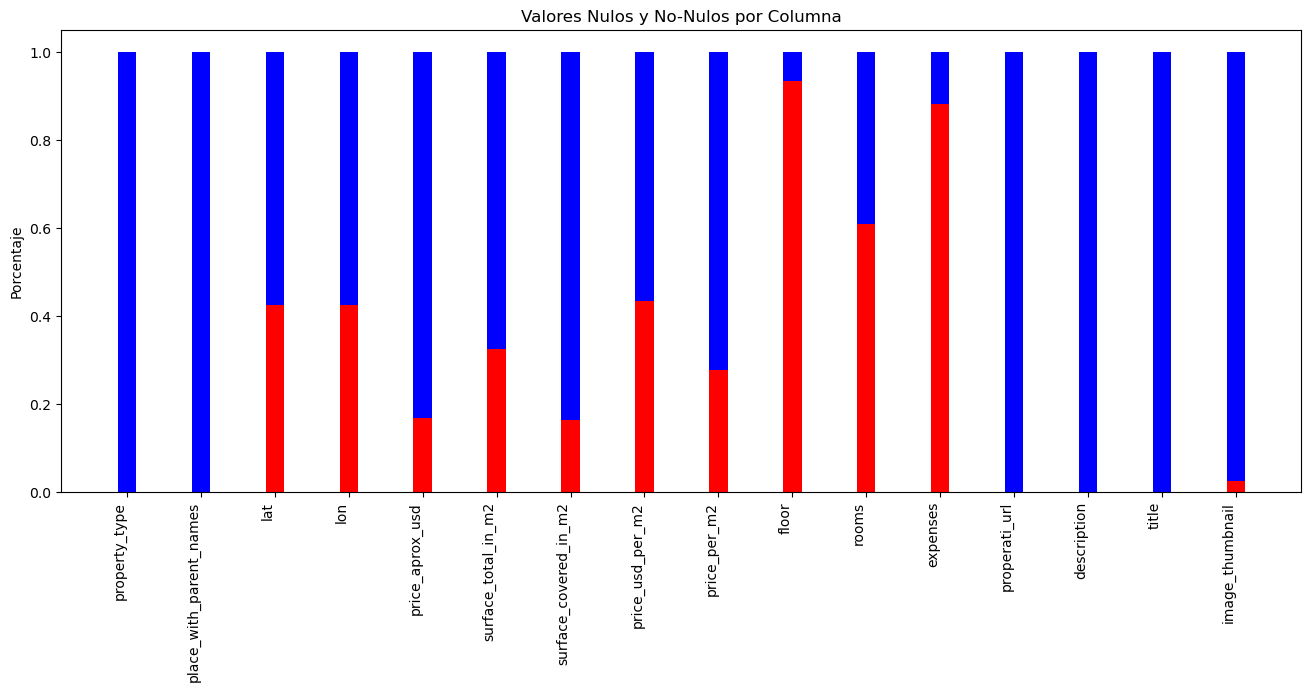

In [92]:
ind=datos.columns
ind_label=np.arange(0,datos.shape[1]-1)

valores_nulos=datos.isnull().sum()/datos.shape[0]

valores_no_nulos=datos.notnull().sum()/datos.shape[0]

width = 0.25

fig = plt.figure(figsize=(16,6)); ax = plt.axes()
#fig2= plt.figure(figsize=(16,6)); ax2 = plt.axes()

ax.bar(ind, valores_nulos, width, color='r') # barra roja. 
ax.bar(ind, valores_no_nulos, width, color='b',bottom=valores_nulos)
#ax2.bar(ind, valores_no_nulos, width, color='b')#, bottom=valores_no_nulos) # barra azul 

ax.set_ylabel('Porcentaje'); ax.set_title('Valores Nulos y No-Nulos por Columna')
#ax.set_xticks(ind); 
ax.set_xticklabels(ind)
ax.tick_params(axis='both', which='minor', labelsize='small')

ax.set_xticklabels(ind, rotation = 90, ha="right")
#ax2.set_xticklabels(ind,labelsize=8)
#ax.legend(labels=['Men', 'Women'])

#plt.gca().invert_xaxis()
plt.show()


C:\Users\rodri\AppData\Local\Temp\ipykernel_13116\3171435013.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['0','20', '40', '60', '80', '100'])


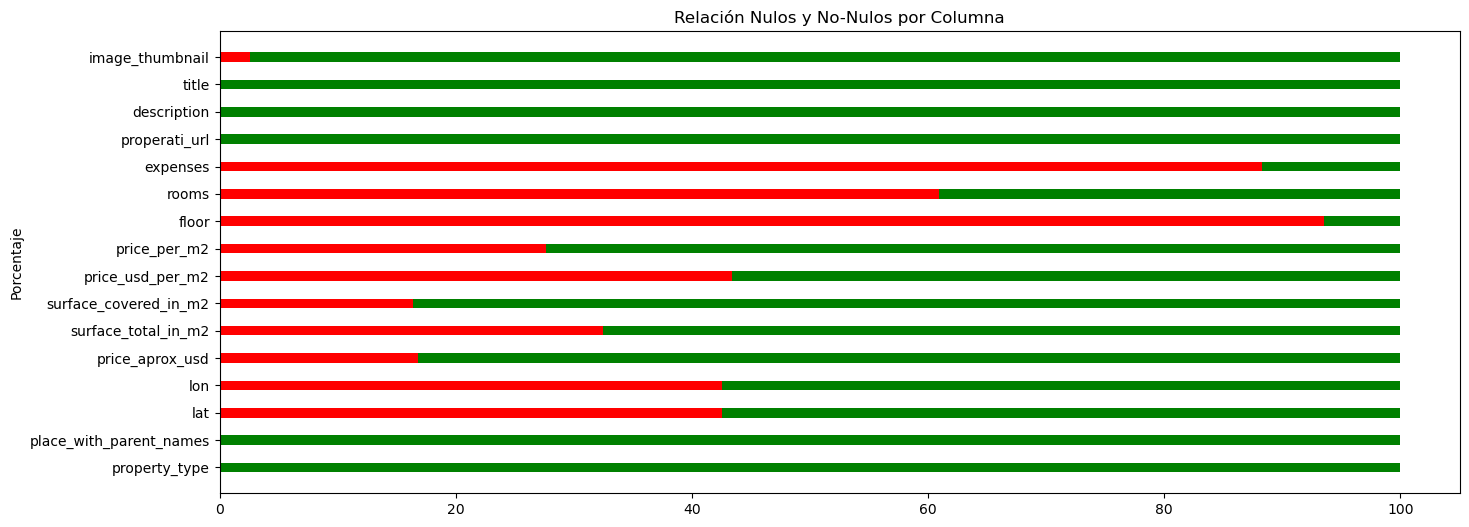

In [93]:
ind=datos.columns
ind_label=np.arange(0,datos.shape[0]-1)

width = 0.35

fig = plt.figure(figsize=(16,6),edgecolor='gray'); ax = plt.axes()
#fig2= plt.figure(figsize=(16,6)); ax2 = plt.axes()

ax.barh(ind, valores_nulos, width, color='r') # barra roja. 
ax.barh(ind, valores_no_nulos, width, color='g',left=valores_nulos)#,right=valores_nulos)
#ax2.bar(ind, valores_no_nulos, width, color='b')#, bottom=valores_no_nulos) # barra azul 

ax.set_ylabel('Porcentaje'); ax.set_title('Relación Nulos y No-Nulos por Columna')
#ax.set_xticks(ind); 

#aca estaba como antes (ind)
#ax.set_xticklabels(ind_label)

#display(ind_label)

ax.tick_params(axis='both', which='minor', labelsize='small')

#ax.set_xticklabels(ind, rotation = 90, ha="right")
#ax2.set_xticklabels(ind,labelsize=8)
#ax.legend(labels=['Men', 'Women'])

ax.set_xticklabels(['0','20', '40', '60', '80', '100'])

#plt.gca().invert_xaxis()
plt.show()

#display(valores_nulos)

#display(valores_no_nulos)

#suma_ambos=valores_nulos+valores_no_nulos

#suma_ambos.value_counts()


In [94]:
#estaria para dropear pric, curency y el precio en moneda local

#usar datos de comentarios para validar, que la información sea consistente 

#validar 

## Procesamiento de columna places para crear nuevas columnas de ubicación geográfica 

In [95]:
#Creo un datafram nuevo separando los campso de la columna places_with_parents
ubicacion = datos_crudos["place_with_parent_names"].str.split('|', expand=True) # Separo en varias columnas
#Visualizamos el dataframe creado:
ubicacion

,0,1,2,3,4,5,6
0,,Argentina,Capital Federal,Mataderos,,None,None
1,,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,,None,None
2,,Argentina,Capital Federal,Mataderos,,None,None
3,,Argentina,Capital Federal,Liniers,,None,None
4,,Argentina,Buenos Aires Costa Atlántica,Mar del Plata,Centro,,None
...,...,...,...,...,...,...,...
121215,,Argentina,Capital Federal,Belgrano,,None,None
121216,,Argentina,Bs.As. G.B.A. Zona Norte,San Isidro,Beccar,,None
121217,,Argentina,Capital Federal,Villa Urquiza,,None,None
121218,,Argentina,Buenos Aires Costa Atlántica,Mar del Plata,Plaza Colón,,None


In [96]:
#Vemos cantidad de valores vacios/nulos en cada columna
for i in range(ubicacion.shape[1]):
    print('Porcentaje vacios en columna', i ,' :' ,ubicacion.iloc[:,i].isna().sum()/ubicacion.shape[0])


Porcentaje vacios en columna 0  : 0.0
Porcentaje vacios en columna 1  : 0.0
Porcentaje vacios en columna 2  : 0.0
Porcentaje vacios en columna 3  : 0.0
Porcentaje vacios en columna 4  : 0.03943243689160204
Porcentaje vacios en columna 5  : 0.6663916845405049
Porcentaje vacios en columna 6  : 0.9954792938459001


Eliminamos la columna 0 por ser un índice redundante, la columna 1 por tener el dato de País que ya decidimos descartar y la columna 6 por su alta tasa de registros vacios.

In [97]:
#Creamos un df con las columnas de interes y el nombre de las columnas
ubicacion_limpia=ubicacion.drop([0,1,6],axis=1,inplace=False)
ubicacion_limpia.columns=['provincia','ciudad','barrio1','barrio2']
ubicacion_limpia

,provincia,ciudad,barrio1,barrio2
0,Capital Federal,Mataderos,,None
1,Bs.As. G.B.A. Zona Sur,La Plata,,None
2,Capital Federal,Mataderos,,None
3,Capital Federal,Liniers,,None
4,Buenos Aires Costa Atlántica,Mar del Plata,Centro,
...,...,...,...,...
121215,Capital Federal,Belgrano,,None
121216,Bs.As. G.B.A. Zona Norte,San Isidro,Beccar,
121217,Capital Federal,Villa Urquiza,,None
121218,Buenos Aires Costa Atlántica,Mar del Plata,Plaza Colón,


In [98]:
#aca pongo capturo los barrios de capital federal que estan en la columna ciudad
#esto se debe a que Capital Federal se guarda en la columna provinci

barrio_limpio=ubicacion_limpia.apply(lambda x: x['ciudad'] if x['provincia'] =='Capital Federal' else x['barrio1'],axis=1)

#precio_m2_imputado=datos.apply(lambda x: x['price']/x['surface_total_in_m2']  if x['price_usd_per_m2'] is np.NAN else x['price_usd_per_m2'], axis=1)
barrio_limpio

0             Mataderos
1                      
2             Mataderos
3               Liniers
4                Centro
              ...      
121215         Belgrano
121216           Beccar
121217    Villa Urquiza
121218      Plaza Colón
121219                 
Length: 121220, dtype: object

In [99]:
ubicacion_limpia['barrio1']=barrio_limpio

In [100]:
ciudad_limpia=ubicacion_limpia.apply(lambda x: x['provincia'] if x['provincia'] =='Capital Federal' else x['ciudad'],axis=1)

In [101]:
ubicacion_limpia['ciudad']=ciudad_limpia

In [102]:
ubicacion_limpia.barrio2.value_counts()

                             39892
Barrio Los Alisos              278
Barrio La Alameda               62
BarrioPortezuelo                54
Barrio Los Lagos                39
Barrio El Golf                  32
Enyoi                           17
Barrio Los Castores             14
QBay Yacht                      13
Barrio Las Glorietas            10
Barrio La Isla                  10
Islas del Canal                  6
Barrio Los Sauces                4
Barrio Barrancas del Lago        4
Barrio Cabos del Lago            3
Barrio Los Tilos                 1
Barrio El Yacht                  1
Name: barrio2, dtype: int64

In [103]:
#aca pruebo sumar las nuevas columnas a nuestro datos
datos[['provincia','ciudad','barrio1','barrio2']]=ubicacion_limpia

In [104]:
datos.sample(30)

,property_type,place_with_parent_names,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail,provincia,ciudad,barrio1,barrio2
111688,house,|Argentina|Bs.As. G.B.A. Zona Norte|Malvinas A...,NaN,NaN,53840.32,130.0,130.0,414.156308,7384.615385,NaN,NaN,NaN,http://www.properati.com.ar/1c626_venta_casa_i...,CASA EN DOS PLANTAS SOBRE LOTE INDIVISO DE 9x...,Casa - Pablo Nogues,https://thumbs4.properati.com/0/KYQFdvDfJCdbus...,Bs.As. G.B.A. Zona Norte,Malvinas Argentinas,Ingeniero Pablo Nogués,
72201,PH,|Argentina|Capital Federal|Villa Real|,-34.624830,-58.525299,86000.00,NaN,40.0,NaN,2150.000000,NaN,NaN,NaN,http://www.properati.com.ar/1alzv_venta_ph_vil...,"Departamento tipo casa de 2 amb/ con patio, pl...","Depto PH 2 amb PB c/patio, en cfte. Oportunidad",https://thumbs4.properati.com/0/ng3SwB7kVcUPCh...,Capital Federal,Capital Federal,Villa Real,None
17986,apartment,|Argentina|Bs.As. G.B.A. Zona Oeste|Morón|Morón|,-34.655814,-58.619857,65000.00,33.0,NaN,1969.696970,NaN,NaN,2.0,1000.0,http://www.properati.com.ar/174pg_venta_depart...,"Departamento 2 ambientes en venta Moron, a cua...",DEPARTAMENTO EN VENTA,https://thumbs4.properati.com/8/aDLi8QGKaSfEG1...,Bs.As. G.B.A. Zona Oeste,Morón,Morón,
44444,apartment,|Argentina|Bs.As. G.B.A. Zona Oeste|Moreno|Mor...,-34.664552,-58.813604,43016.00,NaN,35.0,NaN,1229.028571,NaN,2.0,NaN,http://www.properati.com.ar/190na_venta_depart...,Corredor Responsable: Hernan Perrone - CMCPDJM...,¡Departamento 2 ambientes a estrenar y en cuotas!,https://thumbs4.properati.com/4/8rXw8IaOanWskY...,Bs.As. G.B.A. Zona Oeste,Moreno,Moreno,
42170,apartment,|Argentina|Capital Federal|Belgrano|,-34.553284,-58.451579,170000.00,47.0,47.0,3617.021277,3617.021277,NaN,2.0,NaN,http://www.properati.com.ar/18vx5_venta_depart...,Moderno doble altura vista abierta 47 m totale...,Monroe y Libertador Duplex cochera Balcon dob...,https://thumbs4.properati.com/5/DjIWLkN_9jPdNq...,Capital Federal,Capital Federal,Belgrano,None
88637,apartment,|Argentina|Capital Federal|Belgrano|,NaN,NaN,NaN,52.0,39.0,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/1b7kc_venta_depart...,El precio se compone de un monto en U$S que co...,BE LIBERTADOR - SEGUNDA ETAPA,https://thumbs4.properati.com/7/HlO6oXn-49fW9I...,Capital Federal,Capital Federal,Belgrano,None
78350,apartment,|Argentina|Capital Federal|Palermo|Palermo Hol...,-34.578598,-58.435553,105000.00,35.0,35.0,3000.000000,3000.000000,NaN,NaN,NaN,http://www.properati.com.ar/1au18_venta_depart...,WE THE PEOPLE - HOTEL | ROOM 503 - Frente36 MO...,Departamento - Palermo Hollywood,https://thumbs4.properati.com/1/QBfakD35hVooK2...,Capital Federal,Capital Federal,Palermo,
13578,house,|Argentina|Bs.As. G.B.A. Zona Norte|Malvinas A...,-34.471467,-58.698235,185000.00,450.0,162.0,411.111111,1141.975309,NaN,2.0,NaN,http://www.properati.com.ar/16pog_venta_casa_m...,Casa en venta en el barrio cerrado Santa Maria...,CASA en VENTA en SANTA MARIA DE LOS OLIVOS Bar...,https://thumbs4.properati.com/8/9-l9UUgInbh0AR...,Bs.As. G.B.A. Zona Norte,Malvinas Argentinas,Malvinas Argentinas,
117186,apartment,|Argentina|Santa Fe|Rosario|,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,2.0,NaN,http://www.properati.com.ar/1cdau_venta_depart...,Corredor Responsable: Sebastian Pellegrini - C...,Un dormitorio. Barrio Lourdes. Macrocentro,NaN,Santa Fe,Rosario,,None
31123,house,|Argentina|Bs.As. G.B.A. Zona Norte|General Sa...,-34.591638,-58.545738,300000.00,573.0,217.0,523.560209,1382.488479,NaN,4.0,NaN,http://www.properati.com.ar/183fy_venta_casa_v...,VENTA DE CASA ESTILO AMERICANO EN DOS PLANTAS....,CASA EN VENTA,https://thumbs4.properati.com/9/zKUawVyaRlML3z...,Bs.As. G.B.A. Zona Norte,General San Martín,Villa Libertad,


In [105]:
import matplotlib   
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import plotly.express as px 

In [106]:
df = datos

df

,property_type,place_with_parent_names,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail,provincia,ciudad,barrio1,barrio2
0,PH,|Argentina|Capital Federal|Mataderos|,-34.661824,-58.508839,62000.0,55.0,40.0,1127.272727,1550.000000,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...,Capital Federal,Capital Federal,Mataderos,None
1,apartment,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,-34.903883,-57.964330,150000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...,Bs.As. G.B.A. Zona Sur,La Plata,,None
2,apartment,|Argentina|Capital Federal|Mataderos|,-34.652262,-58.522982,72000.0,55.0,55.0,1309.090909,1309.090909,NaN,NaN,NaN,http://www.properati.com.ar/15bod_venta_depart...,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,https://thumbs4.properati.com/5/SXKr34F_IwG3W_...,Capital Federal,Capital Federal,Mataderos,None
3,PH,|Argentina|Capital Federal|Liniers|,-34.647797,-58.516424,95000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15boh_venta_ph_lin...,PH 3 ambientes con patio. Hay 3 deptos en lote...,PH 3 amb. cfte. reciclado,https://thumbs4.properati.com/3/DgIfX-85Mog5SP...,Capital Federal,Capital Federal,Liniers,None
4,apartment,|Argentina|Buenos Aires Costa Atlántica|Mar de...,-38.002626,-57.549447,64000.0,35.0,35.0,1828.571429,1828.571429,NaN,NaN,NaN,http://www.properati.com.ar/15bok_venta_depart...,DEPARTAMENTO CON FANTÁSTICA ILUMINACIÓN NATURA...,DEPTO 2 AMB AL CONTRAFRENTE ZONA CENTRO/PLAZA ...,https://thumbs4.properati.com/5/xrRqlNcSI_vs-f...,Buenos Aires Costa Atlántica,Mar del Plata,Centro,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121215,apartment,|Argentina|Capital Federal|Belgrano|,NaN,NaN,870000.0,113.0,93.0,7699.115044,9354.838710,NaN,NaN,10000.0,http://www.properati.com.ar/1cja2_venta_depart...,TORRE FORUM ALCORTA - MÁXIMA CATEGORÍA.Impecab...,Torre Forum Alcorta- Impecable 3 ambientes,https://thumbs4.properati.com/1/bjms0KnaAnlNoQ...,Capital Federal,Capital Federal,Belgrano,None
121216,house,|Argentina|Bs.As. G.B.A. Zona Norte|San Isidro...,NaN,NaN,498000.0,360.0,360.0,1383.333333,1383.333333,NaN,NaN,NaN,http://www.properati.com.ar/1cja6_venta_casa_b...,Excelente e impecable casa en Venta en Las Lom...,Ruca Inmuebles | Venta | Lomas de San Isidro |...,https://thumbs4.properati.com/2/PCc3WuQDjpNZc4...,Bs.As. G.B.A. Zona Norte,San Isidro,Beccar,
121217,apartment,|Argentina|Capital Federal|Villa Urquiza|,-34.570639,-58.475596,131500.0,46.0,39.0,2858.695652,3371.794872,NaN,NaN,NaN,http://www.properati.com.ar/1cja7_venta_depart...,VENTA DEPARTAMENTO AMBIENTE DIVISIBLE A ESTREN...,VENTA DEPARTAMENTO AMBIENTE DIVISIBLE A ESTREN...,https://thumbs4.properati.com/9/YAe_-2gRVykADP...,Capital Federal,Capital Federal,Villa Urquiza,None
121218,apartment,|Argentina|Buenos Aires Costa Atlántica|Mar de...,NaN,NaN,95900.0,48.0,48.0,1997.916667,1997.916667,NaN,NaN,NaN,http://www.properati.com.ar/1cja8_venta_depart...,"2 Amb al contrafrente, luminoso. El departame...",2 amb. C/ dep. de servicio al contrafrente| Re...,https://thumbs4.properati.com/8/Q12PTvU6BQJ0ib...,Buenos Aires Costa Atlántica,Mar del Plata,Plaza Colón,


In [107]:
# lat and lon to numeric, errors converted to nan
df['lon'] = pd.to_numeric(df.lon, errors='coerce')
df['lat'] = pd.to_numeric(df.lat, errors='coerce')

# drop rows with missing lat, lon, and intensity
df.dropna(subset=['lon', 'lat'], inplace=True)



<AxesSubplot:xlabel='lat', ylabel='Count'>

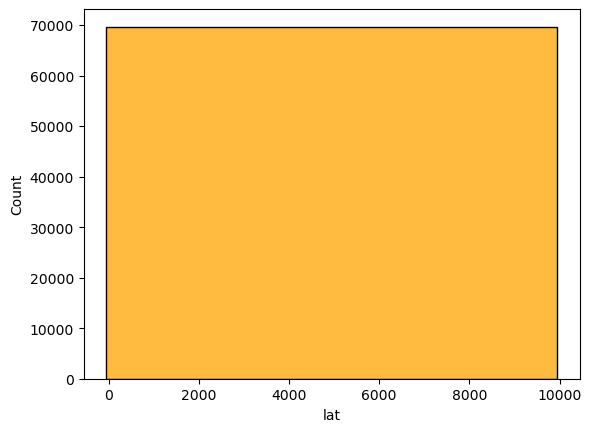

In [137]:
sns.histplot(df['lat'], color = "orange",binwidth=10000)
#sns.histplot(data['y'], bins = 50);

In [108]:
import requests
from keplergl import KeplerGl

In [109]:
map=KeplerGl(height=800, data={"1":df},show_docs=False)
map

C:\Users\rodri\AppData\Roaming\Python\Python39\site-packages\jupyter_client\session.py:718: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(data={'1':        property_type                            place_with_parent_names  \
0              …

In [110]:
#Obtener y almacenar la configuración del mapa ajustado
config=map.config
#Guardar el mapa con la configuración generada
map=KeplerGl(height=800, data={"DENUE":df},show_docs=False, config=config)

C:\Users\rodri\AppData\Roaming\Python\Python39\site-packages\jupyter_client\session.py:718: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


In [111]:
#Salvar mapa
map.save_to_html(config=config, file_name='dataprueba.html')

Map saved to dataprueba.html!


# Roberto: empezamos con el procesamiento de la columna descripción para encontrar data relevante:

In [112]:
# recorre el campo description y llama la funcion CuentaPalabras en cada registro y va sumando palabra y cantidad de cada registro
# Genera un DataFrame CantPalabras con las dos listas
listPalabras = []
listCantidad = []



### ANALIZAR SI CONVIENE REDEFINIR LA FUNCIÓN CUENTAPALABRAS:

AHORA MISMO MODIFICA LAS LISTAS DEFINIDAS POR FUERA DE LA FUNCIÓN, SERÍA MEJOR
UTILIZAR UN RETURN

In [113]:
SerieAmbiente = datos['description']
patron_amb = '\d\s+[Aa]mbiente'
patron_regex_amb = re.compile(patron_amb)
Ambiente = SerieAmbiente.apply(lambda x: np.NaN if len(patron_regex_amb.findall(str(x)))==0
                               else (patron_regex_amb.findall(str(x))[0])[0])
datos['ambientes'] = Ambiente

In [114]:
datos['ambientes'].isnull().sum()

55485

In [115]:
mask_amb=datos['ambientes'].notnull() & datos['rooms'].isnull() 

In [116]:
#se pueden imputar 11 mil datos de la columna ambietnes a rooms
mask_amb.sum()


4762

In [117]:
datos['rooms'].isnull().sum()

27516

Analisis de Cochera 

In [118]:
SerieCoch = datos['description']
patron_coch = '([Cc]ochera|[Gg]arage)'
patron_regex_coch = re.compile(patron_coch)
Cochera = SerieCoch.apply(lambda x: False if len(patron_regex_coch.findall(str(x)))==0 else True)
datos['cochera'] = Cochera

Añado Parrilla

In [119]:
SerieParrilla = datos['description']
patron_parrilla = '[Pp]arrilla'
patron_regex_parrilla = re.compile(patron_parrilla)
Parrilla = SerieParrilla.apply(lambda x: False if len(patron_regex_parrilla.findall(str(x)))==0 else True)
datos['parrilla'] = Parrilla

In [120]:
SeriePatio = datos['description']
patron_patio = '[Pp]atio'
patron_regex_patio = re.compile(patron_patio)
Patio = SeriePatio.apply(lambda x: False if len(patron_regex_patio.findall(str(x)))==0 else True)
datos['patio'] = Patio

In [121]:
SeriePileta = datos['description']
patron_pileta = '([Pp]ileta|[Pp]iscina)'
patron_regex_pileta = re.compile(patron_pileta)
Pileta = SeriePileta.apply(lambda x: False if len(patron_regex_pileta.findall(str(x)))==0 else True)
datos['pileta'] = Pileta

In [122]:
SerieVista = datos['description']
patron_vista = '([Aa]l\s[Ff]rente|[\s.,!/][Vv]istas*[\s.,!/)])'
patron_regex_vista = re.compile(patron_vista)
Vista = SerieVista.apply(lambda x: False if len(patron_regex_vista.findall(str(x)))==0 else True)
datos['vista'] = Vista

In [123]:
# cuando price_usd_m2 es nulo, o bien price_aprox_usd es nulo o surface_total_in_m2 es nulo
# por lo tanto no podemos conformarlo a partir de esos dos valores
datos_usdm2_null = datos[datos['price_usd_per_m2'].isnull()]

In [124]:
# Cuando price_usd_per_m2 es nulo hay muchos registros completos en price_per_m2
# Tomamos sólo los que se encuentran entre 1000 y 6000 que hacen pensar que se cargaron en el campo equivocado
# Son 17.817 valores que llevarían los 52.603 nulos de price_usd_per_m2 a 34.786

mask1 = datos_usdm2_null['price_per_m2'] < 6000
mask2 = datos_usdm2_null['price_per_m2'] > 500
Serie_price_per_m2 = datos_usdm2_null[mask1 & mask2]['price_per_m2']
datos['usd_per_m2_2'] = Serie_price_per_m2

# Busqueda de outliers en variables de precio

<AxesSubplot:xlabel='price_aprox_usd', ylabel='Count'>

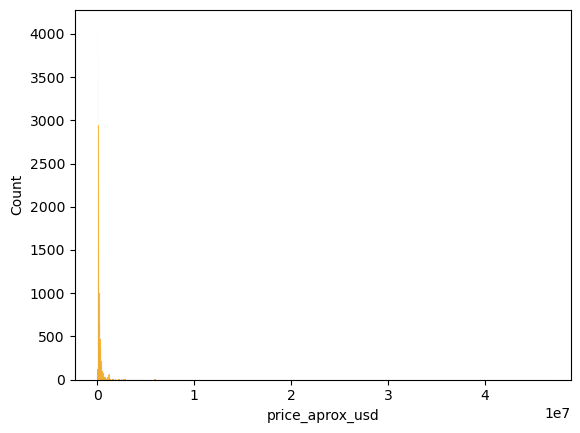

In [125]:
sns.histplot(datos['price_aprox_usd'], color = "orange",binwidth=10000)
#sns.histplot(data['y'], bins = 50);

creo que aca se ve tan feo el histograma porque hay outliers

In [126]:
precio_filtrado=datos['price_aprox_usd']

In [127]:
precio_filtrado2=precio_filtrado.apply(lambda x: 0 if x>2000000 else x)

<AxesSubplot:xlabel='price_aprox_usd', ylabel='Count'>

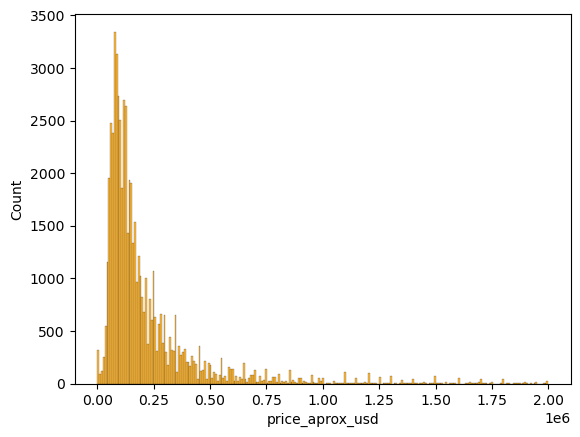

In [128]:
sns.histplot(precio_filtrado2, color = "orange")

C:\Users\rodri\AppData\Local\Temp\ipykernel_13116\3417447459.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(precio_filtrado2, shade=True)


<AxesSubplot:xlabel='price_aprox_usd', ylabel='Density'>

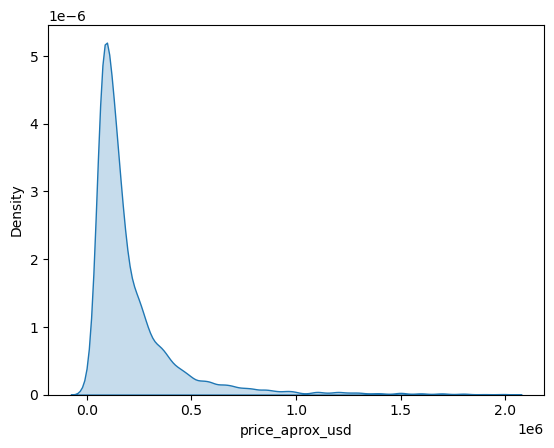

In [129]:
sns.kdeplot(precio_filtrado2, shade=True)

C:\Users\rodri\AppData\Local\Temp\ipykernel_13116\677893732.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(precio_filtrado, shade=True)


<AxesSubplot:xlabel='price_aprox_usd', ylabel='Density'>

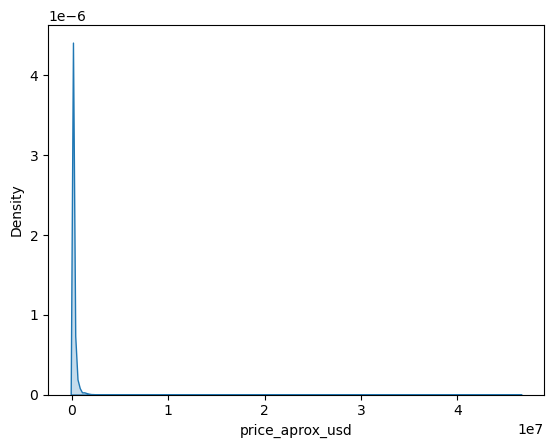

In [130]:
sns.kdeplot(precio_filtrado, shade=True)

<AxesSubplot:>

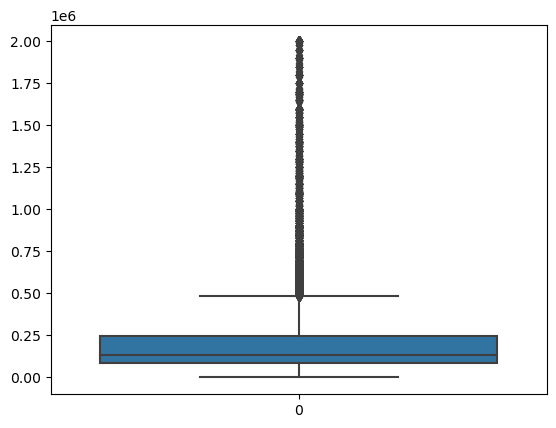

In [131]:
sns.boxplot(precio_filtrado2)

In [132]:
precio_por_provincia=datos[['price_aprox_usd','provincia']]

In [133]:
precio_medio_por_provincia=precio_por_provincia.groupby('provincia').mean()

In [134]:
precio_medio_por_provincia.head(10)
precio_medio_por_provincia

,price_aprox_usd
provincia,
Bs.As. G.B.A. Zona Norte,289098.355367
Bs.As. G.B.A. Zona Oeste,155052.923877
Bs.As. G.B.A. Zona Sur,180168.124655
Buenos Aires Costa Atlántica,137181.794478
Buenos Aires Interior,151028.300872
Capital Federal,259228.713360
Catamarca,106558.980000
Chaco,148769.213043
Chubut,833792.648947
